
# ================================================================
# Encoder–Decoder LSTM pour traduction Anglais–Français
# Dataset : englishfrench.csv (colonnes English, French)

# Lien Data Set: https://drive.google.com/file/d/1OheJMYnZMLVEj4lwFEKL-3fogQkcY9Ae/view?usp=sharing
# ===============================================================

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Embedding, Dense


# ================================================================
# 1-Chargement du dataset
# ================================================================

In [2]:
from google.colab import files

uploaded = files.upload()


Saving englishfrench.csv to englishfrench.csv


In [3]:

df = pd.read_csv("englishfrench.csv", sep=",", engine="python", on_bad_lines="skip")

# Normalisation des noms de colonnes (enlève espaces, met en minuscule)
df.columns = df.columns.str.strip().str.lower()
print("Colonnes détectées :", df.columns.tolist())

# Recherche automatique des colonnes anglaises et françaises
eng_col = [c for c in df.columns if "eng" in c][0]
fr_col = [c for c in df.columns if "fr" in c][0]

# Supprimer les valeurs manquantes
df = df.dropna(subset=[eng_col, fr_col])

# Échantillonnage (pour aller plus vite)
df = df.sample(n=30000, random_state=42).reset_index(drop=True)

# Ajouter les tokens de début et fin
df[fr_col] = df[fr_col].apply(lambda x: f"<start> {x} <end>")

Colonnes détectées : ['english', 'french;;']


# ================================================================
# 2- Tokenisation
# ================================================================

In [4]:
# Anglais
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(df[eng_col])

# Convertir les phrases anglaises en séquences d'indices
eng_sequences = eng_tokenizer.texts_to_sequences(df[eng_col])

# Français (garder tokens spéciaux <start> et <end>)
fr_tokenizer = Tokenizer(filters='', lower=False)  # important !
fr_tokenizer.fit_on_texts(df[fr_col])
fr_sequences = fr_tokenizer.texts_to_sequences(df[fr_col])

# Nombre total de tokens
num_eng_tokens = len(eng_tokenizer.word_index) + 1
num_fr_tokens = len(fr_tokenizer.word_index) + 1

# Longueur maximale des séquences
max_eng_len = max(len(seq) for seq in eng_sequences)
max_fr_len = max(len(seq) for seq in fr_sequences)

# Padding des séquences
encoder_input_data = pad_sequences(eng_sequences, maxlen=max_eng_len, padding='post')
decoder_input_data = pad_sequences(fr_sequences, maxlen=max_fr_len, padding='post')

# Décalage pour le "teacher forcing"
decoder_target_data = np.zeros_like(decoder_input_data)
decoder_target_data[:, :-1] = decoder_input_data[:, 1:]


# ================================================================
# 3- Modèle Encoder–Decoder_LSTM
# ================================================================

In [ ]:
latent_dim = 256

# -------------------------------------------------------
# ENCODER
# -------------------------------------------------------
encoder_inputs = Input(shape=(max_eng_len,))
enc_emb = Embedding(num_eng_tokens, latent_dim, mask_zero=True)(encoder_inputs)
encoder_outputs, state_h, state_c = LSTM(latent_dim, return_state=True)(enc_emb)
encoder_states = [state_h, state_c]

# -------------------------------------------------------
# DECODER
# -------------------------------------------------------
decoder_inputs = Input(shape=(max_fr_len,))

# Embedding français
dec_emb = Embedding(num_fr_tokens, latent_dim, mask_zero=True)(decoder_inputs)

# LSTM du decoder (doit renvoyer les états pour l'inférence)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)

# Passage des états de l'encoder au decoder
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

# Couche Dense finale (softmax sur tout le vocabulaire FR)
decoder_dense = Dense(num_fr_tokens, activation="softmax")

# Sortie finale du modèle
decoder_outputs = decoder_dense(decoder_outputs)

# -------------------------------------------------------
# Modèle global
# -------------------------------------------------------
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 33)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 25, 256)   │  1,935,360 │ input_layer_8[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, 25)        │          0 │ input_layer_8[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 33, 256)   │  4,792,064 │ input_layer_9[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ [(None, 256),     │    525,312 │ embedding_4[0][0… │
│                     │ (None, 256),      │            │ not_equal_4[0][0] │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ [(None, 33, 256), │    525,312 │ embedding_5[0][0… │
│                     │ (None, 256),      │            │ lstm_4[0][1],     │
│                     │ (None, 256)]      │            │ lstm_4[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 33, 18719) │  4,810,783 │ lstm_5[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,588,831 (48.02 MB)

 Trainable params: 12,588,831 (48.02 MB)

 Non-trainable params: 0 (0.00 B)

# ================================================================
# 4- Inférence (traduction)
# ================================================================

In [ ]:

encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = dec_emb
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_outputs2 = decoder_dense(decoder_outputs2)
decoder_states2 = [state_h2, state_c2]

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2
)


# ================================================================
# 5- Entraînement
# ================================================================

Epoch 1/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 51s 114ms/step - accuracy: 0.2250 - loss: 6.3002 - val_accuracy: 0.0815 - val_loss: 4.7331
Epoch 2/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 47s 112ms/step - accuracy: 0.0859 - loss: 4.4096 - val_accuracy: 0.0994 - val_loss: 4.1178
Epoch 3/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 47s 112ms/step - accuracy: 0.1042 - loss: 3.7450 - val_accuracy: 0.1093 - val_loss: 3.7844
Epoch 4/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 47s 112ms/step - accuracy: 0.1155 - loss: 3.2832 - val_accuracy: 0.1158 - val_loss: 3.5712
Epoch 5/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 47s 112ms/step - accuracy: 0.1242 - loss: 2.9292 - val_accuracy: 0.1206 - val_loss: 3.4258
Epoch 6/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 47s 112ms/step - accuracy: 0.1326 - loss: 2.6204 - val_accuracy: 0.1242 - val_loss: 3.3188
Epoch 7/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 47s 112ms/step - accuracy: 0.1394 - loss: 2.3547 - val_accuracy: 0.1279 - val_loss: 3.2424
Epoch 8/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 47s 112ms/step - accuracy: 0.1464 - loss: 2

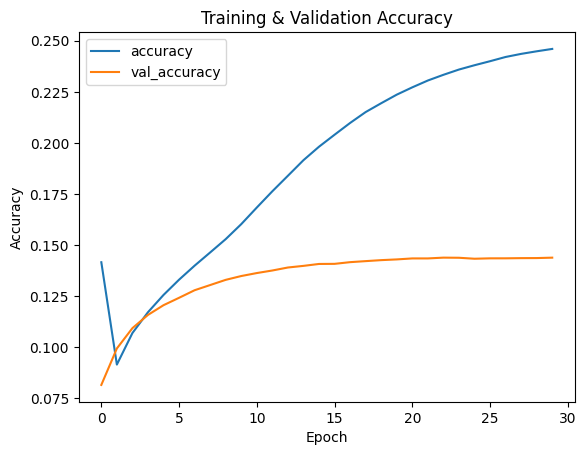

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

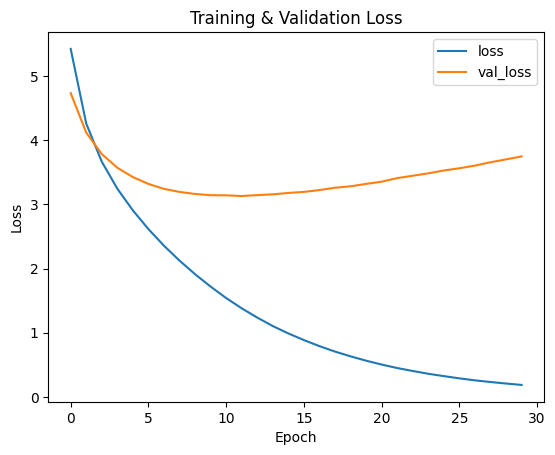

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

X1, X2, y = encoder_input_data, decoder_input_data, decoder_target_data[..., np.newaxis]
X1_train, X1_val, X2_train, X2_val, y_train, y_val = train_test_split(X1, X2, y, test_size=0.1, random_state=42)

history = model.fit(
    [X1_train, X2_train], y_train,
    validation_data=([X1_val, X2_val], y_val),
    batch_size=64,
    epochs=30
)
import matplotlib.pyplot as plt

# Récupération des courbes
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

# Courbe Accuracy
plt.figure()
plt.plot(acc, label="accuracy")
plt.plot(val_acc, label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.savefig("accuracy.png")
plt.show()
from google.colab import files
files.download("accuracy.png")
# Courbe Loss
plt.figure()
plt.plot(loss, label="loss")
plt.plot(val_loss, label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.savefig("loss.png")
plt.show()
from google.colab import files
files.download("loss.png")

# ================================================================
# 6- Fonction de traduction
# ================================================================

In [ ]:

reverse_fr_index = {i: word for word, i in fr_tokenizer.word_index.items()}

def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = fr_tokenizer.word_index["<start>"]
    decoded_sentence = ""

    while True:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = reverse_fr_index.get(sampled_token_index, '')

        if sampled_word == '<end>' or len(decoded_sentence.split()) > max_fr_len:
            break

        decoded_sentence += ' ' + sampled_word
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]

    return decoded_sentence.strip()

# ================================================================
# 7- Test du modèle
# ================================================================

In [ ]:
for i in range(5):
    input_text = df[eng_col][i]
    input_seq = pad_sequences(eng_tokenizer.texts_to_sequences([input_text]), maxlen=max_eng_len, padding='post')
    translation = decode_sequence(input_seq)
    print(f"\n***English: {input_text}")
    print(f"***Prediction Français: {translation}")
    print(f"*** Français (Vérité terain) : {df[fr_col][i]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

***English: Have you ever missed a plane?
***Prediction Français: Avez-vous déjà raté un avion ?;;
*** Français (Vérité terain) : <start> Est-ce que tu as déjà raté un avion ?;; <end>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

***English: The news made her happy.
***Prediction Français: Cette nouvelle la rendit heureuse.;;
*** Français (Vérité terain) : <start> Cette nouvelle la rendit heureuse.;; <end>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

# ================================================================
# 8- Modèle Encoder–Decoder_Bi_LSTM
# ================================================================

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Embedding, Dense
from tensorflow.keras.optimizers import Adam

# =========================
# Hyperparamètres
# =========================
latent_dim = 256
embedding_dim = 128
dropout_rate = 0.3



In [10]:
# =========================
# ENCODEUR BiLSTM
# =========================
encoder_inputs = Input(shape=(max_eng_len,), name="encoder_inputs")
enc_emb = Embedding(
    num_eng_tokens,
    latent_dim,
    mask_zero=True,
    name="encoder_embedding"
)(encoder_inputs)

encoder_bilstm = Bidirectional(
    LSTM(
        latent_dim,
        return_state=True,
        dropout=dropout_rate,
        recurrent_dropout=dropout_rate
    ),
    name="encoder_bilstm"
)

encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_bilstm(enc_emb)

# Fusion des états forward / backward
state_h = Dense(latent_dim, activation="tanh")(forward_h + backward_h)
state_c = Dense(latent_dim, activation="tanh")(forward_c + backward_c)

encoder_states = [state_h, state_c]




In [12]:
# =====================================================
# DÉCODEUR LSTM
# =====================================================
from tensorflow.keras.layers import Dropout

decoder_inputs = Input(shape=(max_fr_len,), name="decoder_inputs")

dec_emb = Embedding(
    num_fr_tokens,
    latent_dim,
    mask_zero=True,
    name="decoder_embedding"
)(decoder_inputs)

dec_emb = Dropout(dropout_rate)(dec_emb)

decoder_lstm = LSTM(
    latent_dim,
    return_sequences=True,
    return_state=True,
    dropout=dropout_rate,
    recurrent_dropout=dropout_rate,
    name="decoder_lstm"
)

decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

decoder_dense = Dense(num_fr_tokens, activation="softmax", name="decoder_dense")
decoder_outputs = decoder_dense(decoder_outputs)


In [13]:
# =========================
# MODÈLE FINAL
# =========================
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 25, 256)   │  1,935,360 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 25)        │          0 │ encoder_inputs[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 33)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_bilstm      │ [(None, 512),     │  1,050,624 │ encoder_embeddin… │
│ (Bidirectional)     │ (None, 256),      │            │ not_equal_1[0][0] │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, 33, 256)   │  4,792,064 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ encoder_bilstm[0… │
│                     │                   │            │ encoder_bilstm[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256)       │          0 │ encoder_bilstm[0… │
│                     │                   │            │ encoder_bilstm[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 33, 256)   │          0 │ decoder_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 33, 256), │    525,312 │ dropout[0][0],    │
│                     │ (None, 256),      │            │ dense[0][0],      │
│                     │ (None, 256)]      │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, 33, 18719) │  4,810,783 │ decoder_lstm[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,245,727 (50.53 MB)

 Trainable params: 13,245,727 (50.53 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# =========================
# ENTRAÎNEMENT
# =========================
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data[..., None],
    batch_size=64,
    epochs=30,
    validation_split=0.2
)


Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 103s 245ms/step - accuracy: 0.1995 - loss: 6.4657 - val_accuracy: 0.0766 - val_loss: 4.8940
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 147s 271ms/step - accuracy: 0.0794 - loss: 4.6176 - val_accuracy: 0.0895 - val_loss: 4.4459
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 92s 244ms/step - accuracy: 0.0932 - loss: 4.1017 - val_accuracy: 0.0988 - val_loss: 4.1200
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 91s 243ms/step - accuracy: 0.1050 - loss: 3.6825 - val_accuracy: 0.1059 - val_loss: 3.8881
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 101s 270ms/step - accuracy: 0.1126 - loss: 3.3527 - val_accuracy: 0.1102 - val_loss: 3.7493
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 91s 243ms/step - accuracy: 0.1179 - loss: 3.0999 - val_accuracy: 0.1129 - val_loss: 3.6684
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 91s 244ms/step - accuracy: 0.1228 - loss: 2.8858 - val_accuracy: 0.1154 - val_loss: 3.5975
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 91s 244ms/step - accuracy: 0.1273 - loss

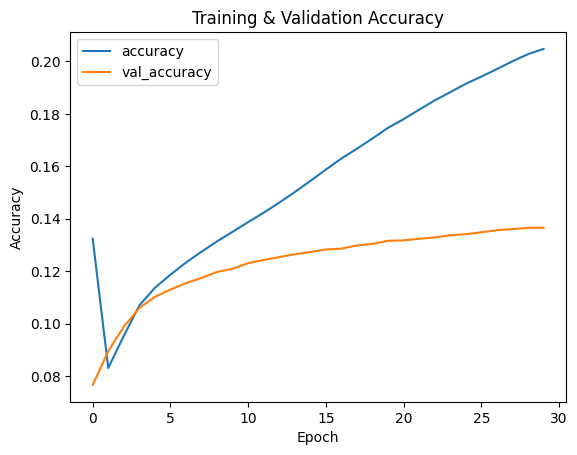

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

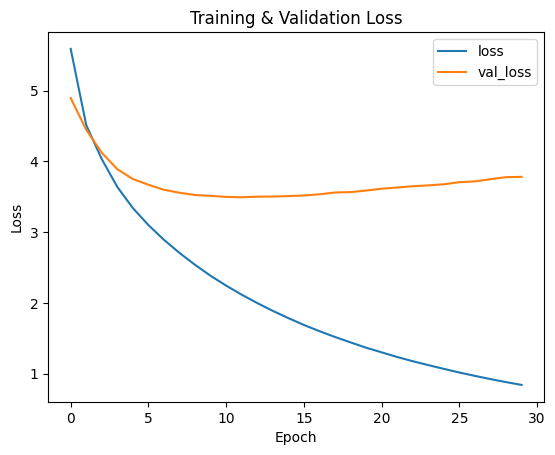

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
import matplotlib.pyplot as plt

# Récupération des courbes
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

# Courbe Accuracy
plt.figure()
plt.plot(acc, label="accuracy")
plt.plot(val_acc, label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.savefig("accuracy.png")
plt.show()
from google.colab import files
files.download("accuracy.png")
# Courbe Loss
plt.figure()
plt.plot(loss, label="loss")
plt.plot(val_loss, label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.savefig("loss.png")
plt.show()
from google.colab import files
files.download("loss.png")

In [18]:

encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = dec_emb
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_outputs2 = decoder_dense(decoder_outputs2)
decoder_states2 = [state_h2, state_c2]

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2
)


In [19]:

reverse_fr_index = {i: word for word, i in fr_tokenizer.word_index.items()}

def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = fr_tokenizer.word_index["<start>"]
    decoded_sentence = ""

    while True:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = reverse_fr_index.get(sampled_token_index, '')

        if sampled_word == '<end>' or len(decoded_sentence.split()) > max_fr_len:
            break

        decoded_sentence += ' ' + sampled_word
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]

    return decoded_sentence.strip()

In [20]:
for i in range(5):
    input_text = df[eng_col][i]
    input_seq = pad_sequences(eng_tokenizer.texts_to_sequences([input_text]), maxlen=max_eng_len, padding='post')
    translation = decode_sequence(input_seq)
    print(f"\n***English: {input_text}")
    print(f"***Prediction Français: {translation}")
    print(f"*** Français (Vérité terain) : {df[fr_col][i]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

***English: Have you ever missed a plane?
***Prediction Français: Avez-vous déjà raté un avion ?;;
*** Français (Vérité terain) : <start> Est-ce que tu as déjà raté un avion ?;; <end>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

***English: The news made her happy.
***Prediction Français: La pièce sentait soudain à la racine de succès.;;
*** Français (Vér